In [1]:
## from ctypes import *
#ctypes.cdll.LoadLibrary('')
#lib1 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libsco.so")
#lib2 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libutils.so")

import sys
sys.path.append('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/deps/sparse_rrt-1')
sys.path.append('.')

from sparse_rrt.planners import SST
#from env.cartpole_obs import CartPoleObs
#from env.cartpole import CartPole
#from sparse_rrt.systems import standard_cpp_systems
from sparse_rrt import _sst_module
import numpy as np
import time
from plan_utility.line_line_cc import *
import pickle
from sparse_rrt import _deep_smp_module, _sst_module
import os
obs_list = []
LENGTH = 20.
width = 6.
near = width * 1.2
# convert from obs to point cloud
# load generated point cloud
obs_list_total = []
obc_list_total = []
for i in range(10):
    file = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/car_obs/obs_%d.pkl' % (i), 'rb')
    obs_list_total.append(pickle.load(file))
    file = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/car_obs/obc_%d.pkl' % (i), 'rb')
    obc_list_total.append(pickle.load(file))

#[(0, 932), (1, 935), (2, 923), (8, 141), (5,931), (7, 927)]
# (5,931), (6, 286)

obs_idx = 5
p_idx = 904

#ignore_list = [(0,900), (1,906), (1,910), (1,907), (2,900)]
ignore_list = []
found = False
print(os.path.isfile('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/results/cpp_full/car_obs/default/paths/path_%d_%d.npy' % (obs_idx, p_idx)))
for obs_idx in range(4,10):
    for p_idx in range(900,1000):
        if (obs_idx, p_idx) in ignore_list:
            continue
        if not os.path.isfile('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/results/cpp_full/car_obs/default/paths/path_%d_%d.npy' % (obs_idx, p_idx)):
            continue
        cost = np.load('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/results/cpp_full/car_obs/default/paths/path_%d_%d.npy' % (obs_idx, p_idx),
               allow_pickle=True)[2].sum()
        data_cost = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/car_obs/%d/cost_%d.pkl' % (obs_idx, p_idx), 'rb')
        data_cost = pickle.load(data_cost).sum()
        start_goal = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/car_obs/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')
        start_goal = pickle.load(start_goal)
        s = start_goal[0]
        g = start_goal[1]
        
        time = np.load('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/results/cpp_full/car_obs/default/time_10_200.npy',
               allow_pickle=True)[obs_idx, p_idx-800]
        sst_time = np.load('/home/arclabdl1/YLmiao/kinodynamics/KinoMPNet/plan_results/car_obs_sst/plan_time.npy',
               allow_pickle=True)[obs_idx, p_idx-800]
        if time <= 20 and time <= sst_time and cost < 1.*data_cost and np.linalg.norm(s-g) >= 60.:
            found = True
            break
    if found:
        break


obs_idx = 8
p_idx = 986
print('obs_idx: ')
print(obs_idx)
print('p_idx:')
print(p_idx)
# obs_idx = 3

# p_idx = 966
# Create custom system
#obs_list = [[-10., -3.],
#            [0., 3.],
#            [10, -3.]]
obs_list = obs_list_total[obs_idx]
obc_list = obc_list_total[obs_idx]
print('generated.')
print(obs_list.shape)

True
obs_idx: 
8
p_idx:
986
generated.
(5, 2)


In [2]:
# search for goal
"""
for p_idx in range(900,1000):
    sgs = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')
    sgs = pickle.load(sgs)
    dis = np.abs(sgs[1]-np.array([np.pi, 0, 0., 0.]))
    if dis[0] >= np.pi:
        dis[0] = 2*np.pi - dis[0]
    if dis[1] >= np.pi:
        dis[1] = 2*np.pi - dis[1]
        
    if np.linalg.norm(dis) <= 1e-1:
        break
print(p_idx)
"""

"\nfor p_idx in range(900,1000):\n    sgs = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')\n    sgs = pickle.load(sgs)\n    dis = np.abs(sgs[1]-np.array([np.pi, 0, 0., 0.]))\n    if dis[0] >= np.pi:\n        dis[0] = 2*np.pi - dis[0]\n    if dis[1] >= np.pi:\n        dis[1] = 2*np.pi - dis[1]\n        \n    if np.linalg.norm(dis) <= 1e-1:\n        break\nprint(p_idx)\n"

In [3]:
params = {
    'solver_type' : "cem",
    'n_problem': 1,
    'n_sample': 1024,
    'n_elite': 128,
    'n_t': 1,
    'max_it': 150,
    'converge_r': 1e-10,

    'dt': 2e-3,

    'mu_u': np.array([1., 1.]) ,
    'sigma_u': np.array([1., 0.5]),

    'mu_t': 1.,
    'sigma_t': 1.,
    't_max': 2.,

    'verbose': False,#True,# 
    'step_size': 0.8,

    "goal_radius": 2.0,

    "sst_delta_near": .001,
    "sst_delta_drain": .0005,
    "goal_bias": 0.08,

    "width": 8,
    "hybrid": False,
    "hybrid_p": 0.0,

    "cost_samples": 1,
    "mpnet_weight_path":"/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/mpnet/exported/output/car_obs/mpnet_10k_external_small_model.pt",
    #"mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_external_v2_deep.pt",
    #"mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k.pt",

    # "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_nonorm.pt",
    # "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_subsample0.5_10k.pt",

    "cost_predictor_weight_path": "/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/mpnet/exported/output/cartpole_obs/cost_10k.pt",
    "cost_to_go_predictor_weight_path": "/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/mpnet/exported/output/cartpole_obs/cost_to_go_10k.pt",

    "refine": False,
    "using_one_step_cost": False,
    "refine_lr": 0,
    "refine_threshold": 0,
    "device_id": "cuda:2",

    "cost_reselection": False,
    "number_of_iterations": 5000,
    "weights_array": [1, 1.0, .5],


}

In [4]:

# params = {
#         'n_problem': 1,
#         'n_sample': 1024,
#         'n_elite': 32,
#         'n_t': 4,
#         'max_it': 200,
#         #'converge_r': 5e-1,
#         'converge_r': 1e-3,
    
#         'dt': 2e-3,
#         'mu_u': np.array([1.0, 0]),
#         'sigma_u': np.array([1.0, 0.5]),
#         'mu_t': .25,
#         'sigma_t': .25,
#         't_max': 0.5,

#         'verbose': True,# False,#
#         'step_size': 0,

#         "goal_radius": 2.0,

#         "sst_delta_near": .1,
#         "sst_delta_drain": .05,
#         "goal_bias": 0.05,

#         "width": 8,
#         "hybrid": False,#True,# 
#         "hybrid_p": 0.0,
        
#         "min_time_steps": 5,
#         "max_time_steps": 100,
    
#         "cost_samples": 1,
#         "mpnet_weight_path":"/home/arclabdl1/YLmiao/kinodynamics/mpc-mpnet-cuda-yinglong/mpnet/exported/output/car_obs/mpnet_10k_external_small_model_step_500.pt",
#         "cost_predictor_weight_path": "/home/arclabdl1/YLmiao/kinodynamics/mpc-mpnet-cuda-yinglong/mpnet/exported/output/acrobot_obs/cost_10k.pt",
#         "cost_to_go_predictor_weight_path": "/home/arclabdl1/YLmiao/kinodynamics/mpc-mpnet-cuda-yinglong/mpnet/exported/output/acrobot_obs/cost_to_go_10k.pt",

#         "refine": False,
#         "using_one_step_cost": False,
#         "refine_lr": 0,
#         "refine_threshold": 0,
#         "device_id": "cuda:3",

#         "cost_reselection": False,
#         "number_of_iterations": 2000,
#         "weights_array": [1, 1.0, 1.],

#     }

In [5]:
# load path
path, control, time = np.load('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/results/cpp_full/car_obs/default/paths/path_%d_%d.npy' % (obs_idx, p_idx),
               allow_pickle=True)

sgs = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/car_obs/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')
sgs = pickle.load(sgs)
print(sgs)
"""
# (7, 927)
path = np.array(
[[ 0.,          0.,          0.,          0.        ],
 [-0.30235064,  0.66357245, -1.12404058,  2.63216073],
 [-0.42513114,  0.98700913, -0.29263858,  1.22161321],
 [ 0.81097696, -2.21064598, -1.87366238, -0.44346807],
 [ 0.43625224, -2.17189627, -2.81821699,  1.07151433],
 [ 1.30897045,  2.50860498,  0.25455659, -1.13373327],
 [ 1.30296453,  2.41413713, -0.5262052, -0.66861023],
 [-1.58742542, -1.43178197, -2.36883756,  4.15048263],
 [-1.88335465, -0.77853767, -0.38750337,  2.06091217],
 [ 1.86185939, -1.89328253,  1.66468725,  3.40569328],
 [ 1.88586336, -0.82441263, -1.47474734,  5.44456514],
 [ 3.02422565,  2.29042714, -1.37086011,  0.0215158 ],
 [ 2.59949331,  2.31621808, -1.51831319,  0.3535678 ],
 [ 2.42948197,  2.37665629, -2.00484496,  0.99423899],
 [-1.57991341, -1.36811145, -2.2772159,   2.70299448],
 [ 2.80394195,  0.71981286,  1.12148533, -1.98584426],
 [ 3.00295891,  0.34951812,  0.73202747, -1.4486524 ],
 [ 3.13364725,  0.10208493, -0.41396637,  0.97824909]])

# (1, 916)
path = np.array(
 [[ 0.,          0.,          0.,          0.        ],
 [-0.14637182,  0.36741907,  0.16802393, -0.09198922],
 [ 0.33910537, -0.53233128,  1.01860863, -2.2462016 ],
 [ 0.45433237, -0.84326897,  0.00979799, -0.67701909],
 [ 0.15750956, -0.76430055, -1.76589893,  2.27511201],
 [ 0.05599173,  2.06468595,  2.89323376, -1.13509309],
 [ 0.70446343,  1.75184533,  1.34005915, -0.63608721],
 [-0.6347062,  -3.02094395, -3.14349578,  2.88615537],
 [-1.29986757, -2.26094529, -0.70598324,  1.6203048 ],
 [ 1.52734201,  1.99942129,  2.90282734, -3.52070003],
 [ 1.89659985,  1.48138215,  1.52561572, -2.66617007],
 [ 2.02352651,  1.23006466,  0.90312322, -2.28778868],
 [ 2.09466351,  0.73102972, -0.39847056, -1.59188   ],
 [ 2.07385742,  0.67449809, -0.88810876, -0.87647985]])
"""
# (8, 914)
"""
path = np.array(
[[ 0.,          0.,          0.,          0.        ],
 [ 0.1708568,  -0.39391056,  0.19467657, -0.62469995],
 [ 0.28792115, -0.91607445,  0.44898465, -1.63658985],
 [-0.95989468,  1.96289103,  0.9317956,   1.43428469],
 [-0.30129242,  2.94121546, -1.83117369,  0.90737314],
 [-0.70691949, -3.12132232, -1.05535802,  0.6535526 ],
 [-0.82442304, -3.03540106,  0.01787491,  0.13220202],
 [ 0.52775011,  2.27083079,  0.37915111, -0.44081038],
 [-1.07891294, -2.37855552, -0.30601515,  1.50195129],
 [ 1.64625095,  2.19734582,  1.28417728, -1.54819197],
 [ 1.75929464,  2.02474293,  0.19036604, -0.80510894],
 [-1.9036383,  -1.9494513,  -1.02537086,  0.82188096],
 [ 2.3872588,   1.49882542,  1.73340551, -2.18197651],])
"""

[array([-15.81041814,  30.02726202,   3.09608061]), array([  3.41530116, -23.70434005,  -2.51230602])]


'\npath = np.array(\n[[ 0.,          0.,          0.,          0.        ],\n [ 0.1708568,  -0.39391056,  0.19467657, -0.62469995],\n [ 0.28792115, -0.91607445,  0.44898465, -1.63658985],\n [-0.95989468,  1.96289103,  0.9317956,   1.43428469],\n [-0.30129242,  2.94121546, -1.83117369,  0.90737314],\n [-0.70691949, -3.12132232, -1.05535802,  0.6535526 ],\n [-0.82442304, -3.03540106,  0.01787491,  0.13220202],\n [ 0.52775011,  2.27083079,  0.37915111, -0.44081038],\n [-1.07891294, -2.37855552, -0.30601515,  1.50195129],\n [ 1.64625095,  2.19734582,  1.28417728, -1.54819197],\n [ 1.75929464,  2.02474293,  0.19036604, -0.80510894],\n [-1.9036383,  -1.9494513,  -1.02537086,  0.82188096],\n [ 2.3872588,   1.49882542,  1.73340551, -2.18197651],])\n'

In [6]:
planner = _deep_smp_module.DSSTMPCWrapper(
    system_type='car_obs',
    solver_type="cem",
    start_state=np.array(path[0]),
#             goal_state=np.array(ref_path[-1]),
    goal_state=np.array(sgs[-1]),
    goal_radius=params['goal_radius'],
    random_seed=0,
    sst_delta_near=params['sst_delta_near'],
    sst_delta_drain=params['sst_delta_drain'],
    obs_list=obs_list,
    width=params['width'],
    verbose=params['verbose'],
    mpnet_weight_path=params['mpnet_weight_path'], 
    cost_predictor_weight_path=params['cost_predictor_weight_path'],
    cost_to_go_predictor_weight_path=params['cost_to_go_predictor_weight_path'],
    num_sample=params['cost_samples'],
    np=params['n_problem'], ns=params['n_sample'], nt=params['n_t'], ne=params['n_elite'], max_it=params['max_it'],
    converge_r=params['converge_r'], mu_u=params['mu_u'], std_u=params['sigma_u'], mu_t=params['mu_t'], 
    std_t=params['sigma_t'], t_max=params['t_max'], step_size=params['step_size'], integration_step=params['dt'], 
    device_id=params['device_id'], refine_lr=params['refine_lr'],
    weights_array=params['weights_array'],
    obs_voxel_array=obc_list.reshape(-1)
)

In [7]:
def enforce_bounds(state):
    '''
    check if state satisfies the bound
    apply threshold to velocity and angle
    return a new state toward which the bound has been enforced
    '''
    WIDTH = 2.0
    LENGTH = 1.0

    STATE_X = 0
    STATE_Y = 1

    STATE_THETA = 2 
    MIN_X = -25
    MAX_X = 25
    MIN_Y = -35
    MAX_Y = 35
    
    
    new_state = np.array(state)
    """
    if state[STATE_V] < MIN_V/30.:
        new_state[STATE_V] = MIN_V/30.
    elif state[STATE_V] > MAX_V/30.:
        new_state[STATE_V] = MAX_V/30.
    """
    if state[2] < -np.pi:
        new_state[2] += 2*np.pi
    elif state[2] > np.pi:
        new_state[2] -= 2*np.pi
    return new_state



def overlap(b1corner,b1axis,b1orign,b1dx,b1dy,b2corner,b2axis,b2orign,b2dx,b2dy):
    # this only checks overlap of b1 w.r.t. b2
    # a complete check should do in both directions
    b2ds = [b2dx, b2dy]
    for a in range(0,2):
        t=b1corner[0][0]*b2axis[a][0]+b1corner[0][1]*b2axis[a][1] # project corner to the axis by inner product

        tMin = t
        tMax = t
        for c in range(1,4):
            t = b1corner[c][0]*b2axis[a][0]+b1corner[c][1]*b2axis[a][1] # project corner to the axis by inner product
            # find range by [tMin, tMax]
            if t < tMin:
                tMin = t
            elif t > tMax:
                tMax = t
        # since b2 the other corners (corner 1, 2, 3) are larger than b2orign (project of corner 0 to axis)
        # specifically, the range is [b2orign[i], b2orign[i]+size(i)] (of the projected point by dot product)
        # we only need to compare tMax with b2orign[i], and tMin with size(i)+b2orign[i]
        if ((tMin > (b2ds[a] + b2orign[a])) or (tMax < b2orign[a])):
            return False

    return True

def IsInCollision(x, obc, obc_width=4.):
    car_width = 2.0
    car_len = 1.0
    width = 8.0
    WIDTH = car_width
    LENGTH = car_len
    STATE_X = 0
    STATE_Y = 1
    STATE_THETA = 2
    MIN_X = -25
    MAX_X = 25
    MIN_Y = -35
    MAX_Y = 35
    if x[0] < MIN_X or x[0] > MAX_X or x[1] < MIN_Y or x[1] > MAX_Y:
        return True
        
    robot_corner=np.zeros((4,2),dtype=np.float32)
    robot_axis=np.zeros((2,2),dtype=np.float32)
    robot_orign=np.zeros(2,dtype=np.float32)
    length=np.zeros(2,dtype=np.float32)
    X1=np.zeros(2,dtype=np.float32)
    Y1=np.zeros(2,dtype=np.float32)

    X1[0]=np.cos(x[STATE_THETA])*(WIDTH/2.0)
    X1[1]=-np.sin(x[STATE_THETA])*(WIDTH/2.0)
    Y1[0]=np.sin(x[STATE_THETA])*(LENGTH/2.0)
    Y1[1]=np.cos(x[STATE_THETA])*(LENGTH/2.0)

    for j in range(0,2):
        # order: (left-bottom, right-bottom, right-upper, left-upper)
        # assume angle (state_theta) is clockwise
        robot_corner[0][j]=x[j]-X1[j]-Y1[j]
        robot_corner[1][j]=x[j]+X1[j]-Y1[j]
        robot_corner[2][j]=x[j]+X1[j]+Y1[j]
        robot_corner[3][j]=x[j]-X1[j]+Y1[j]

        # axis: horizontal and vertical
        robot_axis[0][j] = robot_corner[1][j] - robot_corner[0][j]
        robot_axis[1][j] = robot_corner[3][j] - robot_corner[0][j]

    #print('robot corners:')
    #print(robot_corner)
    length[0]=np.sqrt(robot_axis[0][0]*robot_axis[0][0]+robot_axis[0][1]*robot_axis[0][1])
    length[1]=np.sqrt(robot_axis[1][0]*robot_axis[1][0]+robot_axis[1][1]*robot_axis[1][1])
    # normalize the axis
    for i in range(0,2):
        for j in range(0,2):
            robot_axis[i][j]=robot_axis[i][j]/float(length[i])

    # obtain the projection of the left-bottom corner to the axis, to obtain the minimal projection length
    robot_orign[0]=robot_corner[0][0]*robot_axis[0][0]+ robot_corner[0][1]*robot_axis[0][1]
    robot_orign[1]=robot_corner[0][0]*robot_axis[1][0]+ robot_corner[0][1]*robot_axis[1][1]
    #print('robot orign:')
    #print(robot_orign)
    for i in range(len(obc)):
        cf=True

        obs_corner=np.zeros((4,2),dtype=np.float32)
        obs_axis=np.zeros((2,2),dtype=np.float32)
        obs_orign=np.zeros(2,dtype=np.float32)
        length2=np.zeros(2,dtype=np.float32)

        for j in range(0,2):
            # order: (left-bottom, right-bottom, right-upper, left-upper)
            obs_corner[0][j] = obc[i][j]
            obs_corner[1][j] = obc[i][2+j]
            obs_corner[2][j] = obc[i][2*2+j]
            obs_corner[3][j] = obc[i][3*2+j]
            
            # horizontal axis and vertical
            obs_axis[0][j] = obs_corner[1][j] - obs_corner[0][j]
            obs_axis[1][j] = obs_corner[3][j] - obs_corner[0][j]
            #obs_axis[0][j] = obs_corner[3][j] - obs_corner[0][j]
            #obs_axis[1][j] = obs_corner[1][j] - obs_corner[0][j]

        length2[0]=np.sqrt(obs_axis[0][0]*obs_axis[0][0]+obs_axis[0][1]*obs_axis[0][1])
        length2[1]=np.sqrt(obs_axis[1][0]*obs_axis[1][0]+obs_axis[1][1]*obs_axis[1][1])

        # normalize the axis
        for i1 in range(0,2):
            for j1 in range(0,2):
                obs_axis[i1][j1]=obs_axis[i1][j1]/float(length2[i1])

        # obtain the inner product of the left-bottom corner with the axis to obtain the minimal of projection value
        obs_orign[0]=obs_corner[0][0]*obs_axis[0][0]+ obs_corner[0][1]*obs_axis[0][1]  # dot product at 0-th corner
        obs_orign[1]=obs_corner[0][0]*obs_axis[1][0]+ obs_corner[0][1]*obs_axis[1][1]
        # do checking in both direction (b1 -> b2, b2 -> b1). If at least one shows not-overlapping, then it is not overlapping
        cf=overlap(robot_corner,robot_axis,robot_orign,car_width,car_len,obs_corner,obs_axis,obs_orign,width,width)
        cf=cf and overlap(obs_corner,obs_axis,obs_orign,width,width,robot_corner,robot_axis,robot_orign,car_width,car_len)
        if cf==True:
            return True
    return False

In [8]:
def wrap_angle(x, system):
    circular = system.is_circular_topology()
    res = np.array(x)
    for i in range(len(x)):
        if circular[i]:
            # use our previously saved version
            res[i] = x[i] - np.floor(x[i] / (2*np.pi))*(2*np.pi)
            if res[i] > np.pi:
                res[i] = res[i] - 2*np.pi
    return res


In [16]:
from visual.visualizer import Visualizer
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
padding = 3

class CarVisualizer(Visualizer):
    def __init__(self, system, params):
        super(CarVisualizer, self).__init__(system, params)
        self.dt = 2
        self.fig = plt.gcf()
        self.fig.set_figheight(10)
        self.fig.set_figwidth(10)
        self.ax1 = plt.subplot(111)
    def _init(self):
        ax = self.ax1
        ax.clear()
        ax.set_xlim(-25-padding, 25+padding)
        ax.set_ylim(-35, 35)
        # add patches
        state = self.states[0]
        self.car = patches.Rectangle((state[0]-self.params['car_w']/2,state[1]-self.params['car_l']/2),\
                                       self.params['car_w'],self.params['car_l'],\
                                      linewidth=.5,edgecolor=self.color_dict['car_start_color'],\
                                      facecolor=self.color_dict['car_start_color'])
        self.car_direction = patches.Arrow(state[0],state[1],\
                                               self.params['car_w'] * 2.,0,\
                                               linewidth=0., width=1.5, \
                                           facecolor=self.color_dict['direction_start_color'])
        self.recs = []
        self.recs.append(self.car)
        self.recs.append(self.car_direction)
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor=self.color_dict['obstacle_color'],\
                                      facecolor=self.color_dict['obstacle_color'])
            self.recs.append(obs)
            ax.add_patch(obs)
        # transform pole according to state
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], state[1], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.car.set_transform(t)
        ax.add_patch(self.car)
        self.car_direction.set_transform(t)
        self.car_direction_patch = ax.add_patch(self.car_direction)

        # add goal patch
        state = self.states[-1]
        self.car_goal = patches.Rectangle((state[0]-self.params['car_w']/2,state[1]-self.params['car_l']/2),\
                                       self.params['car_w'],self.params['car_l'],\
                                      linewidth=.5,edgecolor=self.color_dict['car_goal_color'],\
                                      facecolor=self.color_dict['car_goal_color'])
        self.car_direction_goal = patches.Arrow(state[0],state[1],\
                                               self.params['car_w'] * 2.,0,\
                                               linewidth=0, width=1.5, \
                                               facecolor=self.color_dict['direction_goal_color'])

        self.recs.append(self.car_goal)
        self.recs.append(self.car_direction_goal)
        
        # transform pole according to state
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], state[1], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.car_goal.set_transform(t)
        ax.add_patch(self.car_goal)
        self.car_direction_goal.set_transform(t)
        self.car_direction_goal_patch = ax.add_patch(self.car_direction_goal)


        return self.recs
    def _animate(self, i):
        ax = self.ax1
        ax.set_xlim(-25-padding, 25+padding)
        ax.set_ylim(-35, 35)
        state = self.states[i]
        self.recs[0].set_xy((state[0]-self.params['car_w']/2,state[1]-self.params['car_l']/2))
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], state[1], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.recs[0].set_transform(t)

        # modify car_direction
        self.car_direction_patch.remove()
        self.car_direction = patches.Arrow(state[0],state[1],\
                                           self.params['car_w']/2,0,\
                                      linewidth=1.0, edgecolor=self.color_dict['direction_start_color'])
        self.recs[1] = self.car_direction
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], state[1], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.recs[1].set_transform(t)
        self.car_direction_patch = ax.add_patch(self.car_direction)
        
        return self.recs



    def animate(self, states, actions, costs, obstacles, sg, wrap_system):
        '''
        given a list of states, actions and obstacles, animate the robot
        '''

        new_obs_i = []
        obs_width = 8.0
        for k in range(len(obstacles)):
            obs_pt = []
            obs_pt.append(obstacles[k][0]-obs_width/2)
            obs_pt.append(obstacles[k][1]-obs_width/2)
            obs_pt.append(obstacles[k][0]+obs_width/2)
            obs_pt.append(obstacles[k][1]-obs_width/2)
            obs_pt.append(obstacles[k][0]+obs_width/2)
            obs_pt.append(obstacles[k][1]+obs_width/2)
            obs_pt.append(obstacles[k][0]-obs_width/2)
            obs_pt.append(obstacles[k][1]+obs_width/2)
            new_obs_i.append(obs_pt)
        obs_i = new_obs_i
        self.cc_obs = obs_i

        # transform the waypoint states and actions into trajectory
        traj = []
        s = states[0]
        for i in range(len(states)-1):
            s = states[i]
            print('state: %d, remaining: %d' % (i, len(states)-i))
            #action = actions[i]
            
            # connect from this state to next
            solution_u, solution_t = planner.steer_solution(states[i], states[i+1])
            print('solution_u:')
            print(solution_u)
            print('solution_t:')
            print(solution_t)
            for j in range(len(solution_u)):
                action = solution_u[j]
                num_steps = int(np.round(solution_t[j]/self.params['integration_step']))

                for k in range(num_steps):
                    traj.append(np.array(s))
                    #print("porpagating...")
                    #print(s)
                    #print('st:')
                    #print(sT)
                    s = self.system(s, action, self.params['integration_step'])
                    s = enforce_bounds(s)
                    #assert not IsInCollision(s, obs_i)
            print('after propagation, state: ', s)
            print('state to reach: ', states[i+1])
            
        traj = np.array(traj)
        return traj
    def plot(self, traj, obstacles, sg, color_dict, wrap_system):
        self.fig = plt.gcf()
        self.fig.set_figheight(10)
        self.fig.set_figwidth(10)
        self.ax1 = plt.subplot(111)
        
        self.color_dict = color_dict
        
        print("animating...")
        # animate
        self.states = traj
        self.obs = obstacles
        print(len(self.states))
        self.total = len(self.states)
        self._init()
        
        to_plot_list_x = []
        to_plot_list_y = []
        traj_recs = []
        plot_step_sz = 500
        for i in list(range(1,len(traj))) + [0]:
            if i % plot_step_sz == 0:
                # plot the scene change
                if i == 0:
                    car_color = color_dict['car_start_color']#"green"
                    direction_color = color_dict['direction_start_color']#"yellow"
                else:
                    car_color = color_dict['car_intermediate_color']#"blue"
                    direction_color = color_dict['direction_intermediate_color']#"yellow"
                ax = self.ax1
                ax.set_xlim(-25-padding, 25+padding)
                ax.set_ylim(-35, 35)
                state = traj[i]
                car = patches.Rectangle((state[0]-self.params['car_w']/2,state[1]-self.params['car_l']/2),\
                                                       self.params['car_w'],self.params['car_l'],\
                                                      linewidth=1.,edgecolor=car_color,facecolor=car_color,\
                                                      fill=False)
                car_direction = patches.Arrow(state[0],state[1],\
                                                       self.params['car_w']/2,0,\
                                                       linewidth=1.0, edgecolor=direction_color)
                t = mpl.transforms.Affine2D().rotate_deg_around(state[0], state[1], \
                                                                -state[2]/np.pi * 180) + ax.transData
                car.set_transform(t)
                ax.add_patch(car)
                car_direction.set_transform(t)
                #car_direction_patch = ax.add_patch(car_direction)

                traj_recs.append(car)
                #traj_recs.append(car_direction)
                
        ax.add_patch(self.car_goal)
        ax.add_patch(self.car_direction_goal)
        plt.axis('off')
        return self.fig
        #plt.savefig("car_mpc_obs_%d_p_%d.png" % (obs_idx, p_idx), bbox_inches='tight')


        
        """
        # for thesis
        fig = plt.figure()
        ax = plt.subplot(121)
        ax.set_xlim(-40, 40)
        ax.set_ylim(-40, 40)
        fig.set_figheight(5)
        fig.set_figwidth(10)
        
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor='black',facecolor='black')
            self.recs.append(obs)
            ax.add_patch(obs)
        ax.plot(to_plot_list_x[0], to_plot_list_y[0], alpha=1, c='green')
        ax.plot(to_plot_list_x[-1], to_plot_list_y[-1], alpha=1, c='red')
        
        ax = plt.subplot(122)
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)
        dtheta = 0.1
        feasible_points = []
        infeasible_points = []
        imin = 0
        imax = int(2*np.pi/dtheta)

        for i in range(imin, imax):
            for j in range(imin, imax):
                x = np.array([dtheta*i-np.pi, dtheta*j-np.pi, 0., 0.])
                if IsInCollision(x, self.cc_obs):
                    infeasible_points.append(x)
                else:
                    feasible_points.append(x)
        feasible_points = np.array(feasible_points)
        infeasible_points = np.array(infeasible_points)

        print('feasible points')
        print(feasible_points)
        print('infeasible points')
        print(infeasible_points)
        #scat_feas =ax.scatter(feasible_points[:,0], feasible_points[:,1], c='white')
        scat_infeas = ax.scatter(infeasible_points[:,0], infeasible_points[:,1], c='black')
        scat_state = ax.scatter(sg[0][0], sg[0][1], c='green', s=50.0)
        scat_state = ax.scatter(sg[1][0], sg[1][1], c='red', s=50.0, marker='*')
        """


states:
[[-15.81041814  30.02726202   3.09608061]
 [-17.24608557  29.61762283   2.69279571]
 [-19.27056572  28.38239824   2.66755933]
 [-21.03646843  27.14570797   2.36830648]
 [-22.06863207  25.5706987    2.19667505]
 [-22.84978374  24.20394727   1.97149729]
 [-23.0755459   22.69785645   1.69118315]
 [-22.86603696  20.73216402   1.18848719]
 [-22.17121962  18.86784033   1.28424322]
 [-21.54501053  16.8674101    1.20739582]
 [-21.21896343  16.30511355   1.00784475]
 [-21.20565823  16.28825332   0.90451053]
 [-21.20491712  16.28731072   0.90376806]
 [-21.19663933  16.27739716   0.86318357]
 [-20.90431536  16.10606249   0.49126622]
 [-20.10429906  15.90230484   0.08836329]
 [-18.35400897  15.89481569  -0.16203771]
 [-16.59853737  15.91830827   0.1500118 ]
 [-14.98881316  15.58289402   0.30911043]
 [-13.15482554  15.09201762   0.2944543 ]
 [-11.32272295  14.08096587   0.74489434]
 [ -9.70020311  12.46595958   0.88429385]
 [ -8.65463331  10.63609034   1.03711782]
 [ -7.39065952   8.7972426

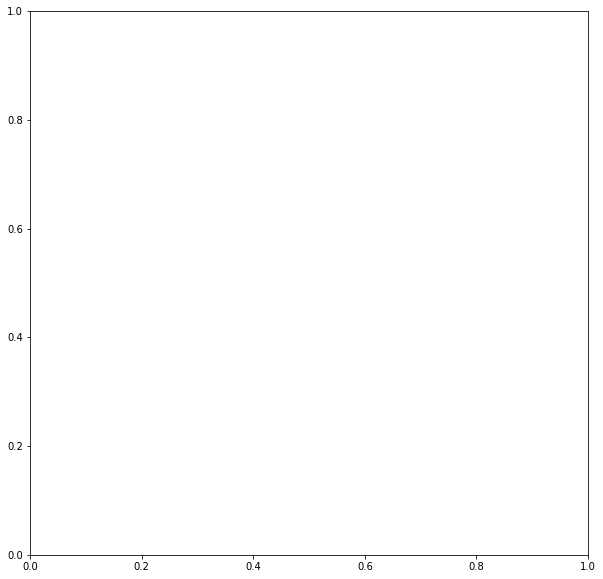

In [10]:
params = {}
car_width = 2.0
car_len = 1.0
width = 8.

params['car_w'] = car_width
params['car_l'] = car_len
params['obs_w'] = width
params['obs_h'] = width
params['integration_step'] = 0.002

system = _sst_module.Car()
cpp_propagator = _sst_module.SystemPropagator()
dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)

vis = CarVisualizer(dynamics, params)
states = path
sgs[0] = wrap_angle(sgs[0], system)
sgs[1] = wrap_angle(sgs[1], system)
print('states:')
print(states)
traj = vis.animate(np.array(states), None, None, obs_list, np.array(sgs), system)
#HTML(anim.to_html5_video())
#anim.save('acrobot_env%d_path%d.mp4' % (obs_idx, p_idx))

<ipython-input-16-9b093ea26e97>:157: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.ax1 = plt.subplot(111)


animating...
27474


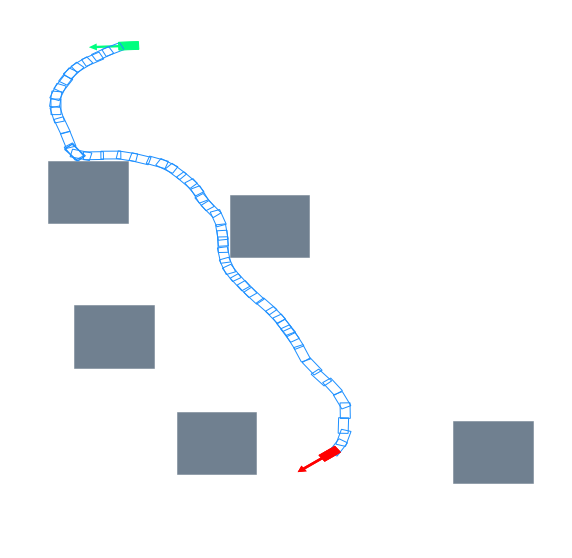

In [17]:
color_dict = {'car_start_color': 'springgreen', 'direction_start_color': 'springgreen',
              'car_intermediate_color': 'dodgerblue', 'direction_intermediate_color': 'yellow',
              'car_goal_color': 'red', 'direction_goal_color': 'red',
              'obstacle_color': 'slategray'}
vis = CarVisualizer(dynamics, params)

fig = vis.plot(traj, obs_list, np.array(sgs), color_dict, system)
plt.savefig("car_mpc_obs_%d_p_%d.pdf" % (obs_idx, p_idx), bbox_inches='tight')

In [12]:
print(obs_idx)
print(p_idx)


8
986
